In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os, cv2, random

2023-01-06 22:31:25.264467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 22:31:25.375773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 22:31:25.375793: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-06 22:31:25.992366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## AlexNet on CIFAR-10

In [2]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

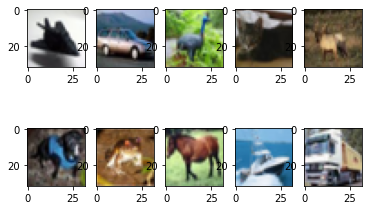

In [4]:
(x,id) = np.unique(y_train, return_index=True)
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[id[i]])

In [5]:
#Maximum Value
np.max(x_train[0])

255

In [6]:
#Minimum Value
np.min(x_train[0])

0

In [7]:
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [8]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))  
    return image,label

In [9]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [10]:
train_ds=(train_ds.map(process_image).shuffle(buffer_size=train_ds_size).batch(batch_size=32,drop_remainder=True))
test_ds=(test_ds.map(process_image).shuffle(buffer_size=test_ds_size).batch(batch_size=32,drop_remainder=True))

In [11]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(7,7), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    ])

In [12]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 128)       18944     
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
history=model.fit(train_ds,epochs=25,validation_data=test_ds,validation_freq=1)

Epoch 1/25
1562/1562 [==============================] - 36s 14ms/step - loss: 1.9327 - accuracy: 0.2957 - val_loss: 1.5103 - val_accuracy: 0.4614
Epoch 2/25
1562/1562 [==============================] - 20s 11ms/step - loss: 1.5421 - accuracy: 0.4441 - val_loss: 1.3393 - val_accuracy: 0.5176
Epoch 3/25
1562/1562 [==============================] - 20s 11ms/step - loss: 1.3675 - accuracy: 0.5092 - val_loss: 1.2336 - val_accuracy: 0.5597
Epoch 4/25
1562/1562 [==============================] - 20s 10ms/step - loss: 1.2481 - accuracy: 0.5546 - val_loss: 1.1530 - val_accuracy: 0.5892
Epoch 5/25
1562/1562 [==============================] - 22s 11ms/step - loss: 1.1507 - accuracy: 0.5924 - val_loss: 1.1017 - val_accuracy: 0.6107
Epoch 6/25
1562/1562 [==============================] - 20s 11ms/step - loss: 1.0648 - accuracy: 0.6211 - val_loss: 1.0582 - val_accuracy: 0.6313
Epoch 7/25
1562/1562 [==============================] - 20s 11ms/step - loss: 0.9927 - accuracy: 0.6507 - val_loss: 1.0191 -

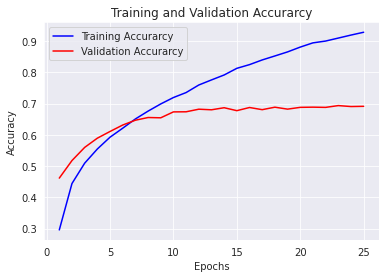

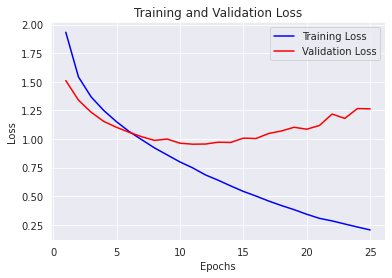

In [14]:
#Plotting The Graphs for Accuracy and Loss of Model1
sns.set_style("darkgrid")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.6935096383094788
